here we import the data and libraries
then do a Data Inspection and remove outliers

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333


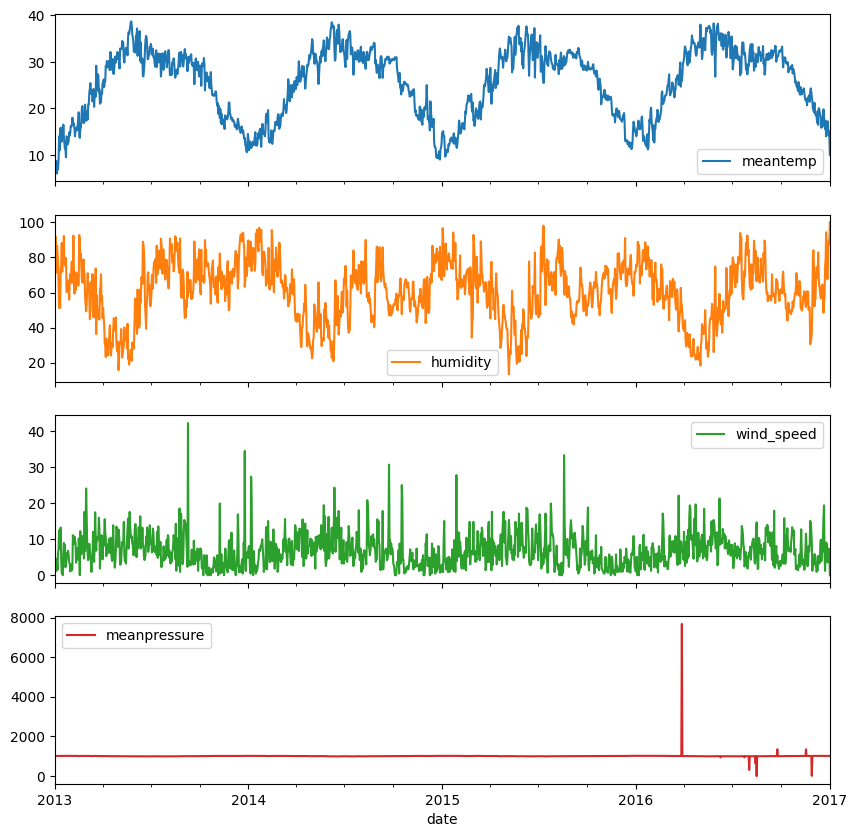

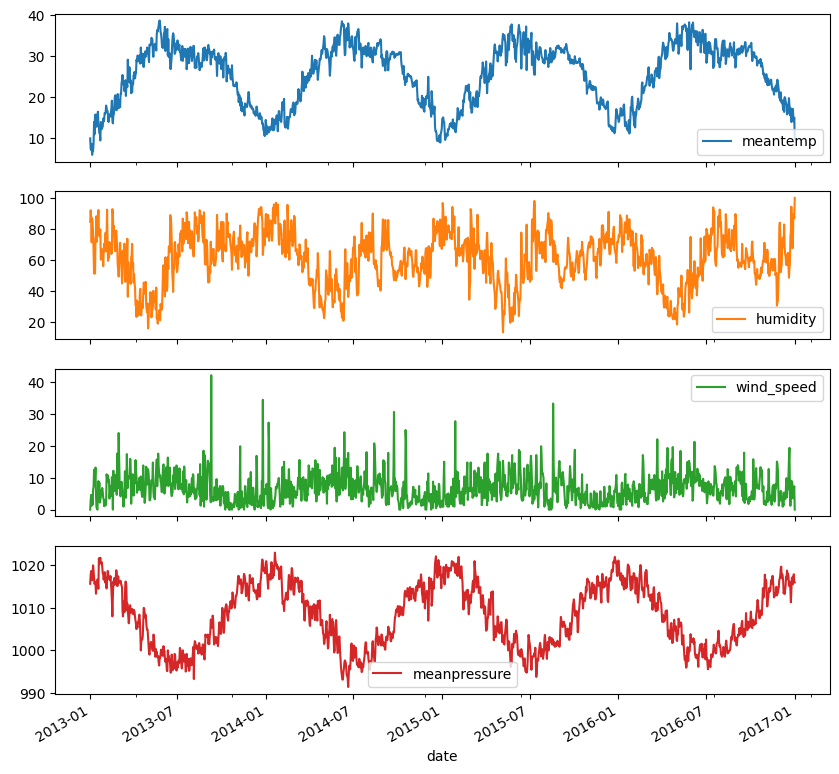

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Load the training dataset
train_data = pd.read_csv("/kaggle/input/dataset-climate/DailyDelhiClimateTrain.csv", parse_dates=['date'], index_col='date')

# Load the test dataset
test_data = pd.read_csv("/kaggle/input/dataset-climate/DailyDelhiClimateTest.csv", parse_dates=['date'], index_col='date')

# Display the first few rows of the datasets
print(train_data.head())
print(test_data.head())

# Data Inspection
# Plot the data to visually inspect for any anomalies or trends
train_data.plot(subplots=True, figsize=(10, 10))
plt.show()

# Detect and Remove Outliers in 'meanpressure'
Q1 = train_data['meanpressure'].quantile(0.25)
Q3 = train_data['meanpressure'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_data = train_data[(train_data['meanpressure'] >= lower_bound) & (train_data['meanpressure'] <= upper_bound)]

# Check the data after removing outliers
train_data.plot(subplots=True, figsize=(10, 10))
plt.show()


here we combine the datas to scale the features from 0 to 1
then we have a function to create a time_series input for our model training

In [21]:
combined_data = pd.concat([train_data, test_data])

# Feature Processing
# Scale the features
scaler = MinMaxScaler()
scaled_combined_data = scaler.fit_transform(combined_data)

# Split the scaled data back into train and test sets
scaled_train_data = scaled_combined_data[:len(train_data)]
scaled_test_data = scaled_combined_data[len(train_data):]

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


here we split back the data to train and test and then reshape the x

In [22]:
n_steps =30
X_train, y_train = split_sequence(scaled_train_data, n_steps)
X_test, y_test = split_sequence(scaled_test_data, n_steps)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [23]:
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=20)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.3498
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0047
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0027
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0026
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0024
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0022
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0020
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0023
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0018
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0018
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0015
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0017
Epoch 13/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0014
Epoch 14/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0013
Epoch 15/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0013
E

In [24]:
y_pred = model.predict(X_test)

# Inverse scale the predictions
y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), scaled_combined_data.shape[1] - 1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), scaled_combined_data.shape[1] - 1)), y_pred), axis=1))[:, -1]

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
MAE: 2.2114423202840485
MSE: 8.123176536680337
RMSE: 2.85011868817429
R-squared: 0.7069221673050518


In [25]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,893 (2.28 MB)

 Trainable params: 199,297 (778.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 398,596 (1.52 MB)

In [26]:
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=100,batch_size=20)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.1422
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0036
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0033
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0023
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0018
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0017
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0015
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0012
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0011
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0011
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 8.9789e-04
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 7.6596e-04
Epoch 13/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 7.5283e-04
Epoch 14/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 6.1889e-04
Epoch 15/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step 

In [27]:
y_pred = regressorGRU.predict(X_test)

# Inverse scale the predictions
y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), scaled_combined_data.shape[1] - 1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), scaled_combined_data.shape[1] - 1)), y_pred), axis=1))[:, -1]

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
MAE: 2.3746156903552356
MSE: 9.049048567752786
RMSE: 3.0081636537517014
R-squared: 0.6735174312397593


In [28]:
regressorGRU.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 30, 50)         │         8,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 30, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 30, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,404 (423.46 KB)

 Trainable params: 54,201 (211.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54,203 (211.73 KB)